<a href="https://colab.research.google.com/github/MahdyMokh7/AI-Different-Searches/blob/master/AI_CA1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Problem description:

We have a matrix n*n that some of its cells are 1 and some are 0. the 1 represent the open lamps and the 0s represent the closed lamps. by selecting each cell the selected cell and their adjacent neighbors get toggled and their state changes. we want to try and find the optimal solution that is by sellecting the least amount of cells, all the lamps get turned off(all the cells become 0).


## Solution:

We are trying different search agorithms to find the solution to our problem written in the description. We will compare them to see witch search does better overal.

The searches being used are


*  **BFS**(Breadth-first search)

*  **IDS**(Iterative-deepening search)

*  **A* search**

*  **weighted A* search**

For A* we use 3 different kinds of heuristics that we will explain each individualy later on.


In [2]:
import random
import itertools
import copy
import heapq
from dataclasses import dataclass, field
from typing import List, Tuple, Callable, Any, Set
import numpy as np
from time import time
from tabulate import tabulate
import threading
import collections
import sys
from math import ceil
from enum import Enum
import math
import heapq
import copy
import numpy as np
from typing import List, Tuple, Callable
from collections import deque
import copy
from typing import List, Tuple

## Que1.

Now let's explain the different modeling parts of our problem.

### State:
Each matrix that consists of 0&1s is a unique state. we have nXn cells that can be either 1 or 0 so in total we could have 2^(nXn) unique states. so a state is the positioning of on/off lights in the board.

### Initial State:
The begining positioning of the 0 and 1s given by the random board creater(input) that we want to solve.

### Goal State:
The last state that we want to achieve and get to that state which is the all 0 n*n matrix.

### Action:
In each state the action is that we can select any of the n*n cells and the adjacent cells and itself will toggle.

### Path:
The path is the connection of a state with another state via some actions and the path cost is the sum of the number of actions that we took becuase each action costs 1.

In [3]:
class LightsOutPuzzle:
    """
    Class of Our Board(state)..........
    """
    def __init__(self, board: List[List[int]]):
        self.board = np.array(board, dtype=np.uint8)  # matrix board
        self.size = len(board)
        self.moves = [(x, y) for x in range(self.size) for y in range(self.size)]
        self.solution = []
        self.f = 0
        self.g = 0

    def toggle(self, x, y):  # toggling the pox(x, y)
        for dx, dy in [(0, 0), (1, 0), (-1, 0), (0, 1), (0, -1)]:
            nx, ny = x + dx, y + dy
            if 0 <= nx < self.size and 0 <= ny < self.size:
                self.board[nx, ny] ^= 1
        self.solution.append((x, y))

    def make_child_with_action(self, x, y):
        new_puzzle = LightsOutPuzzle(self.board.tolist())
        new_puzzle.solution = self.solution.copy()

        new_puzzle.g = self.g
        new_puzzle.f = self.f

        new_puzzle.toggle(x, y)

        return new_puzzle


    def is_solved(self):   # is our problem solved
        return np.all(self.board == 0)

    def get_actions(self):  # returns all possible moves(actions) (every cell of the n*n matrix)
        return self.moves

    def __str__(self):
        return '\n'.join(' '.join(str(cell) for cell in row) for row in self.board)

    def __eq__(self, other):
        return np.array_equal(self.board, other.board)

    def __hash__(self):
        return hash(self.board.tobytes())


For the above class, I added the  __hash__ and __eq__ methods so that when I compared two puzzles it would understand that it should compare their matrix boards.

When I wanted to add the puzzle in my explored or frontier sets because the object would have been saved if I had another board with the same matrix of 0s and 1s it would not have said they are identical because the classes differed. Still, now I'm making the hash if the object file myself by overriding it. Now the hash is created by the matrix board, not the object file, because our states are our matrix boards.

In [4]:
def create_random_board(size: int, seed: int, num_toggles: int = None):
    """
    return and makes the board that is a numpy array with the values 1&0..........
    """
    random.seed(time() if seed is None else seed)

    board = [[0 for _ in range(size)] for _ in range(size)]
    puzzle = LightsOutPuzzle(board)  # an all 0 matrix n*n board

    if num_toggles is None:
        num_toggles = random.randint(1, size * size)

    for _ in range(num_toggles):  # making some parts 1 via number of togles
        x = random.randint(0, size - 1)
        y = random.randint(0, size - 1)
        puzzle.toggle(x, y)

    return puzzle.board

print()

In [5]:
def show_solution(  # when finished the algorithm and you want to print the answer
    puzzle: LightsOutPuzzle,
    solution: List[Tuple[int, int]],
    algorithm_name: str,
    nodes_visited: int,
    show_steps: bool = False,
):
    print(f"\nSolving with {algorithm_name}:")
    if solution is None:
        print("No solution found.")
        return
    print(f"Solution: {solution}")
    print(f"Nodes visited: {nodes_visited}")
    if show_steps:
        print("\nSolution steps:")
        for i, move in enumerate(solution):
            print(f"\nStep {i+1}: Toggle position {move}")
            puzzle.toggle(*move)
            print(puzzle)
        print(
            "\nFinal state (solved):"
            if puzzle.is_solved()
            else "\nFinal state (not solved):"
        )
        print(puzzle)

I separated the tests and the results of the different board sizes so that at the end, for my plots I could compare them more precisely.

In [6]:
tests_3x3 = [  # all boards
    create_random_board(3, 42),
    create_random_board(3, 41),
    create_random_board(3, 42, 5)]
tests_4x4 = [
    create_random_board(4, 42),
    create_random_board(4, 41),
    create_random_board(4, 42, 5)
]
tests_5x5 = [
    create_random_board(5, 42),
    create_random_board(5, 41),
    create_random_board(5, 42, 5),
]

### BFS Search:

We wanna discus how does bfs work.

At first it starts with the initial state by using a queue (FIFO) we store all the state that via an action we could reach (all the succesors) and then when all of them get saved we epand the head of the queue and store all their succesors in the queue that (they are our frontiers waiting to get expanded) we store the expanded node(state) in the set (python hash map) and further go depth 1, 2, 3, ... until it reaches the goal State that means we found a solution to the problem.

Because we say in bfs we search depth to depth we insure that we found the **complete** and the **optimal solution.**

**Optimal solution:** is that we reach the goal state in minimum actions possible and bfs ensures that. (its one of bfs's properties)

Becuase of searching all the possible state before realy getting deap to any of it and in practice we are checking all the states in a way so it usualy takes more time to find the solution and more visited nodes and in some matrixes like 5*5 it may not even be possible to get a result from it because of the time constraints.

I have made some comments in the code where at first I implemented the sets in another way and used iterable search to find if it was in our queue or not and I made deep copying, but these were to much time-consuming (the queue one was a disaster because of the O(n) now its average of O(1) used hash maps) I changed them for better data structure and better and more efficient structure as I mentioned in the code

In [7]:
# TODO: Must return a list of tuples and the number of visited nodes
def bfs_solve(puzzle: LightsOutPuzzle) -> Tuple[List[Tuple[int, int]], int]:

    initial_board = puzzle.board
    num_of_states_checked = 0

    explored_set_boards = set()  # the nodes that been visited and expanded before

    frontier_set = set()
    queue_frontier = deque()  # the nodes that been visited before
    frontier_set.add(puzzle)  # newly added for efficiency / hashing change from tuple ravel to the own class haashing
    queue_frontier.append(puzzle)

    # check the initial state
    if puzzle.is_solved():
        return puzzle.solution, 1

    while True:
        if len(queue_frontier) == 0:  # exit the loop solution not found
            return [], 0

        cur_puzzle = queue_frontier.popleft()  # poping the tail of the queue
        frontier_set.remove(cur_puzzle)  # removing from the set also
        explored_set_boards.add(cur_puzzle)  # the poped node that we are exploring its child gets add to the explored set


        for action in cur_puzzle.get_actions():
            puzzle_temp = cur_puzzle.make_child_with_action(*action)  # make child / changed deep copy for eficiency

            if not puzzle_temp in frontier_set:  # if the node isn't in the frontiers
                if not puzzle_temp in explored_set_boards:  # if the node isn't in the expanded
                    num_of_states_checked += 1
                    if puzzle_temp.is_solved():
                        return puzzle_temp.solution, num_of_states_checked
                    queue_frontier.append(puzzle_temp)
                    frontier_set.add(puzzle_temp)

    return [], 0

### IDS search:

We want to discuss how the IDS search work

IDS search is short for iterative deepening search. The combination of bfs and dfs has the benefits of using low memory of dfs and the benefits of finding the complete and optimal soltution of bfs. But it sacrifices some time and the time complexity in terms of order is as the same as bfs $O(b^d)$
but it's consts is more costly. The ids always consumes more time than the bfs but in the other hand it's space compelxity is $O(b*d)$ much less than bfs's  $O(b^d)$.

When to use it depends on the problem and our constraints. For search problems that we dont know how much will the tree grow its better to use ids so it could have enough space for the nodes in search. If we know that our memory will be enough for the search it will always be better to use bfs.

This search does a depth-limited search for each depth so its a dfs but with depth constraint. For example when it's limit is depth d it has visited the nodes in the depths 1 to d-1 multipule times(depth 1 d times, depth 2 d-1 times, ..., depth d 1 time).

It ensures a **optimal** and **complete** soltution.

IDS could be implemented both with stack and recursively. I chose to implement it recursively as our source book prefers because of its simplicity. I will lose a bit of time efficiency and somewhat more memory space is needed.

Further explanations are commented in the code.


In [8]:
def dls(cur_puzzle: LightsOutPuzzle, limit: int, explored_set_boards: set, num_of_states_checked: int) -> Tuple[List[Tuple[int, int]], int]:
    if cur_puzzle.is_solved():  # check initial state
        return cur_puzzle.solution, num_of_states_checked

    if limit == 0:
        return "cutoff", num_of_states_checked

    cutoff_occurred = False

    for action in cur_puzzle.get_actions():
        puzzle_temp = cur_puzzle.make_child_with_action(*action)  # make child / changed deep copy for eficiency

        if puzzle_temp not in explored_set_boards:  # If the node isn't in the expanded set
            explored_set_boards.add(puzzle_temp)
            num_of_states_checked += 1
            result, num_of_states_checked = dls(puzzle_temp, limit - 1, explored_set_boards, num_of_states_checked)  # recursive call

            if result == "cutoff":
                cutoff_occurred = True
            elif result != "failure":
                return result, num_of_states_checked

    return ("cutoff" if cutoff_occurred else "failure"), num_of_states_checked

def ids_solve(puzzle: LightsOutPuzzle) -> Tuple[List[Tuple[int, int]], int]:
    num_of_states_checked = 0
    depth = 1

    while True:
        explored_set_boards = set()  # the nodes that have been visited and expanded before
        result, num_of_states_checked = dls(puzzle, depth, explored_set_boards, num_of_states_checked)

        if result != "cutoff" and result != "failure":
            return result, num_of_states_checked
        elif result == "failure":
            return [], 0

        depth += 1  # expanding the depth to find the solution


### A* search:

A* an informed search. This search is different than the other two searches, we prioritize which states are better to go meaning which action is better to choose at each state and we prioritize action by an estimation that is called our heuristic function.

f = heuristic() + real_cost

The heuristic function returns the estimated cost making that action in a state, and then it will be added to the real cost of making that particular action (in this problem each action has the cost of 1 because it will just mean that we toggled a node ), so we will use the heapq library so that when we want to select a child it selects the min in terms of cost to reach the solution.

How better our heuristic function could estimate the cost we will find the solution in less time, but in bad heuristic functions this search could take more time than bfs even ids. So it all depends on the heuristic functions behavior.


### Weighed A* search:

Its just like the A* search with a alpha const coefficient always being multiplied to the heuristic function then getting added with the real cost.

f = alpha*heuristic() + real_cost



In [9]:
def astar_solve(puzzle: LightsOutPuzzle, heuristic: Callable[[LightsOutPuzzle], int]) -> Tuple[List[Tuple[int, int]], int]:

    initial_board = puzzle.board
    num_of_states_checked = 0

    counter = itertools.count()

    explored_set_boards = set()
    priority_queue_frontier = []  # the nodes that have been visited before
    frontier_set = set()
    heapq.heappush(priority_queue_frontier, (puzzle.f, next(counter), puzzle))  # Add unique counter to avoid comparison issues
    frontier_set.add(puzzle)

    # check the initial state
    if puzzle.is_solved():
        return puzzle.solution, 1

    while True:
        if len(priority_queue_frontier) == 0:  # exit the loop if solution not found
            # return cur_puzzle.solution, num_of_states_checked
            return [], 0

        _, _, cur_puzzle = heapq.heappop(priority_queue_frontier)
        frontier_set.remove(cur_puzzle)

        if cur_puzzle.is_solved():
            return cur_puzzle.solution, num_of_states_checked
        explored_set_boards.add(cur_puzzle)

        for action in cur_puzzle.get_actions():
            puzzle_temp = cur_puzzle.make_child_with_action(*action)  # make child

            if not puzzle_temp in frontier_set:  # Compare with the third element in the tuple
                if not puzzle_temp in explored_set_boards:  # if the node isn't in the expanded
                    num_of_states_checked += 1
                    if puzzle_temp.is_solved():
                        return puzzle_temp.solution, num_of_states_checked
                    puzzle_temp.g += 1
                    puzzle_temp.f = puzzle_temp.g + heuristic(puzzle_temp)
                    heapq.heappush(priority_queue_frontier, (puzzle_temp.f, next(counter), puzzle_temp))
                    frontier_set.add(puzzle_temp)

    return [], 0

### Heuristic 1:



*   Number of ones divided by 5 (as we want less ones, the best state is all 0)
*   It is **admisible** (in each action the most 1s we could turm to 0 is 5 so at least n_of_ones/5 actions is needed to reach goal state, meaning $h(n) \leq \text{realCost}(n)$
)
*   It is **consistent** (each action's real cost is a const value one at worst case if all 5 ones became 0 this equation will be equal and other times greater so its correct, meaning
$h(n) \leq \text{realCost}(n \to n') + h(n')$
)


### Heuristic 2:



*   Number of clusters of ones (because each cluster in a way could be removed with one action and we want less clusters of ones, the best state is to have no clusters of ones)
*  It's *not neccesirly admisible or consistent*. Because the implementation isn't very precise.
*  It may lead to some wrong estimations although in some cases it works better than the rest.


### Heuristic 3:


*   Min distance from the center
*  It's *not neccesirly admisible or consistent*. Because its a more fundamental heuristic than a techniqal one.
* In some small cases it works better than the rest.
* It may be interasting for you to know the way I figured this heurustic was that at first I was using the exact oposite meaning the max distance from the center and it first eliminated those 1s and worked poorly so I changed it to first remove the ones in near the center beacause it will affect the most of The board and the edges will be the little parts to fix as in the center we could change 5 lamps with one action despite in the edges the number reduces to 4 or 3.



In [10]:
# TODO: Implement heuristic functions and store them in the list
def heuristic1(puzzle: LightsOutPuzzle):
    """
    number of 1s divided by 5
    """
    board = puzzle.board  # board is numpy 2d-array
    return np.sum(board) / 5

def heuristic2(puzzle: LightsOutPuzzle):
    """
    number of clusters
    """
    board = puzzle.board  # board is numpy 2d-array
    num_rows, num_cols = board.shape
    j_col = 0
    h_value = 0  #  hueristic value
    for i_row in range(num_rows):
        while j_col < num_cols:
            if board[i_row, j_col] == 1:
                h_value += 1
                j_col += 3
            else:
                j_col += 1
        j_col = 0
    return h_value

def heuristic3(puzzle: LightsOutPuzzle):
    """
    max distance to middle
    """
    board = puzzle.board  # board is numpy 2d-array
    num_rows, num_cols = board.shape
    mid_pos = (puzzle.size // 2, puzzle.size // 2)
    h_value = float("inf")  #  hueristic value
    for i_row in range(num_rows):
        for j_col in range(num_cols):
            if board[i_row, j_col] == 1:
                h_value = min(h_value, abs(mid_pos[0] - i_row) + abs(mid_pos[1] - j_col))
            else:
                j_col += 1
        j_col = 0
    return h_value

heuristics = [heuristic1, heuristic2, heuristic3]

The explanations are given above in the heuristic section.

In this part, we will just give weights (coefficients) to the heuristics. So if a heuristic estimates well this will help its approximation, otherwise it worstens its case.

In [11]:
# TODO: Implement weighted heuristic functions and store them in the list
def weighted_heuristic1(puzzle: LightsOutPuzzle, alpha = 5):
    return heuristic1(puzzle) * alpha

def weighted_heuristic2(puzzle: LightsOutPuzzle, alpha = 5):
    return heuristic2(puzzle) * alpha

def weighted_heuristic3(puzzle: LightsOutPuzzle, alpha = 5):
    return heuristic3(puzzle) * alpha

weighted_heuristics = [weighted_heuristic1, weighted_heuristic2, weighted_heuristic3]

# TODO: assign 2 weights you wanna run
weights = [2, 5]

In [12]:
class SearchStatus(Enum):
    SOLVED = "Solved"
    TIMEOUT = "Timeout"
    NO_SOLUTION = "No Solution"

@dataclass
class SearchResult:
    result: SearchStatus
    solution: Any = None
    nodes_visited: int = None
    time: float = None

    def __str__(self):
        output = f"Result: {self.result.value}\n"
        if self.result == SearchStatus.SOLVED:
            output += f"Solution: {self.solution}\n"
        if self.result != SearchStatus.TIMEOUT:
            output += f"Nodes Visited: {self.nodes_visited}\n"
            output += f"Time Taken: {self.time:.3f} seconds\n"

        return output


DEFAULT_SEARCH_RESULT = SearchResult(SearchStatus.TIMEOUT, None, None, float("inf"))

In [13]:
import signal

class TimeoutException(Exception):
    pass
def handle_timeout(signum, frame):
    print("")
    raise TimeoutException()

def run_searches(func: Callable, args: Any, time_limit: float = 60.0, name: str = "") -> SearchResult:

    signal.signal(signal.SIGALRM, handle_timeout)

    signal.alarm(int(time_limit))

    start_time = time()

    try:

        solution, nodes_visited = func(*args)
        signal.alarm(0)
        time_taken = time() - start_time
        show_solution(args[0], solution, name, nodes_visited)
        return SearchResult(SearchStatus.SOLVED if solution else SearchStatus.NO_SOLUTION, solution, nodes_visited, time_taken)

    except TimeoutException:
        print(f"\nTime limit of {time_limit} seconds exceeded for {name}")
        return SearchResult(SearchStatus.TIMEOUT)

    except Exception as e:
        raise e

    finally:
        signal.alarm(0)

In [14]:
from functools import partial


def run_test(test: List, heuristics: List[Callable[[Any], int]], time_limit: float = 60.0):
    """
    just call this function with the correct parameters and wait for the results......
    """

    print(f"Running test:\n {test}")

    puzzle = LightsOutPuzzle(test)  # makes an object of the board

    bfs_result = run_searches(bfs_solve, (puzzle,), name="BFS", time_limit=time_limit)
    ids_result = run_searches(ids_solve, (puzzle,), name="IDS", time_limit=time_limit)

    astar_results = []
    for heuristic in heuristics:
        astar_results.append(
            run_searches(
                astar_solve,
                (puzzle, heuristic),
                name=f"A*({heuristic.__name__})",
                time_limit=time_limit,
            )
        )

    weighted_astar_results = []
    for heuristic in weighted_heuristics:
        for weight in weights:
          weighted_astar_results.append(
              run_searches(
                  astar_solve,
                  (puzzle, partial(heuristic, alpha = weight)),  # for the weighted part it adds the alpha with this notation to the hueristic function
                  name=f"weighted A*({heuristic.__name__}, alpha = {weight})",
                  time_limit=time_limit,
              )
          )

    print("\n-------------------------------\n")

    return (
        test,
        bfs_result,
        ids_result,
        *astar_results,
        *weighted_astar_results
    )

In [15]:
results_3x3: List[Tuple[str, SearchResult, SearchResult, SearchResult, SearchResult]] = []
results_4x4: List[Tuple[str, SearchResult, SearchResult, SearchResult, SearchResult]] = []
results_5x5: List[Tuple[str, SearchResult, SearchResult, SearchResult, SearchResult]] = []

for test in tests_3x3:  # the tests is our matrixes but not the object the matrix board
    results_3x3.append(run_test(test, heuristics, 1.0))  # why do we pass the heuristics and not the weighted hueristics

for test in tests_4x4:
    results_4x4.append(run_test(test, heuristics, 5.0))

for test in tests_5x5:
    results_5x5.append(run_test(test, heuristics, 120.0))

results_all = results_3x3 + results_4x4 + results_5x5

Running test:
 [[1 1 1]
 [1 1 1]
 [1 0 0]]

Solving with BFS:
Solution: [(0, 2), (1, 0)]
Nodes visited: 25

Solving with IDS:
Solution: [(0, 2), (1, 0)]
Nodes visited: 29

Solving with A*(heuristic1):
Solution: [(1, 0), (0, 2)]
Nodes visited: 19

Solving with A*(heuristic2):
Solution: [(1, 0), (0, 2)]
Nodes visited: 19

Solving with A*(heuristic3):
Solution: [(0, 2), (1, 0)]
Nodes visited: 19

Solving with weighted A*(weighted_heuristic1, alpha = 2):
Solution: [(1, 0), (0, 2)]
Nodes visited: 19

Solving with weighted A*(weighted_heuristic1, alpha = 5):
Solution: [(1, 0), (0, 2)]
Nodes visited: 19

Solving with weighted A*(weighted_heuristic2, alpha = 2):
Solution: [(1, 0), (0, 2)]
Nodes visited: 19

Solving with weighted A*(weighted_heuristic2, alpha = 5):
Solution: [(1, 0), (0, 2)]
Nodes visited: 19

Solving with weighted A*(weighted_heuristic3, alpha = 2):
Solution: [(0, 2), (1, 0)]
Nodes visited: 19

Solving with weighted A*(weighted_heuristic3, alpha = 5):
Solution: [(0, 2), (1, 0)

In [16]:
table_data: List[List[str]] = []

for result in results_all:
    table_data.append(
        [
            "\n".join(" ".join(str(cell) for cell in row) for row in result[0]),
            str(result[1]),
            str(result[2]),
        ]
    )

    for i in range(len(heuristics)):
        table_data[-1].append(str(result[3 + i]))

    for i in range(len(weighted_heuristics)):
        for j in range(len(weights)):
          table_data[-1].append(str(result[3 + len(heuristics) + i * 2 + j]))

    table_data.append("\n\n\n")

if table_data[-1] == "\n\n\n":
    table_data.pop()

print(len(table_data))
print("Results:")
print(
    tabulate(
        table_data,
        headers=[
            "Test",
            "BFS",
            "IDS",
            *[f"A* ({heuristic.__name__})" for heuristic in heuristics],
            *[f"Weighted A* ({heuristic.__name__}, alpha = {weight})" for heuristic in weighted_heuristics for weight in weights]
        ],
        floatfmt=".3f",
        numalign="center",
        stralign="center",
        tablefmt="grid",
    )
)

17
Results:
+-----------+--------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------+--------------------------------------------------------------------+----------------------------------------------------+--------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------------------------------------------+------------------------------------------------------------+
|   Test    |  

The table that the project wnated us to fill is exactly this table.

In [17]:
algos = ["BFS", "IDS", "A_STAR1", "A_STAR2", "A_STAR3", "WEIGHTED_A_STAR1_2", "WEIGHTED_A_STAR1_5", "WEIGHTED_A_STAR2_2", "WEIGHTED_A_STAR2_5", "WEIGHTED_A_STAR3_2", "WEIGHTED_A_STAR3_5"]

In [18]:
from typing import List, Tuple

def pre_process_results(results: List[Tuple[str, SearchResult, SearchResult, SearchResult, SearchResult]], attribute: str):
    new_dict = {algo: 0 for algo in algos}

    print("Expected length of results: ", len(results))
    print("Expected length of each result tuple: ", len(results[0]))

    counter = 0
    for result in results:
        counter += 1
        for algo, i in zip(algos, range(1, 12)):
            new_dict[algo] += getattr(result[i], attribute)

    return {key: value / counter for key, value in new_dict.items()}


In [19]:
dict_algorithms_times_3x3 = pre_process_results(results_3x3, "time")
dict_algorithms_times_4x4 = pre_process_results(results_4x4, "time")
# dict_algorithms_times_5x5 = pre_process_results(results_5x5, "time")

dict_algorithms_nodes_3x3 = pre_process_results(results_3x3, "nodes_visited")
dict_algorithms_nodes_4x4 = pre_process_results(results_4x4, "nodes_visited")
# dict_algorithms_nodes_5x5 = pre_process_results(results_5x5, "nodes_visited")

Expected length of results:  3
Expected length of each result tuple:  12
Expected length of results:  3
Expected length of each result tuple:  12
Expected length of results:  3
Expected length of each result tuple:  12
Expected length of results:  3
Expected length of each result tuple:  12


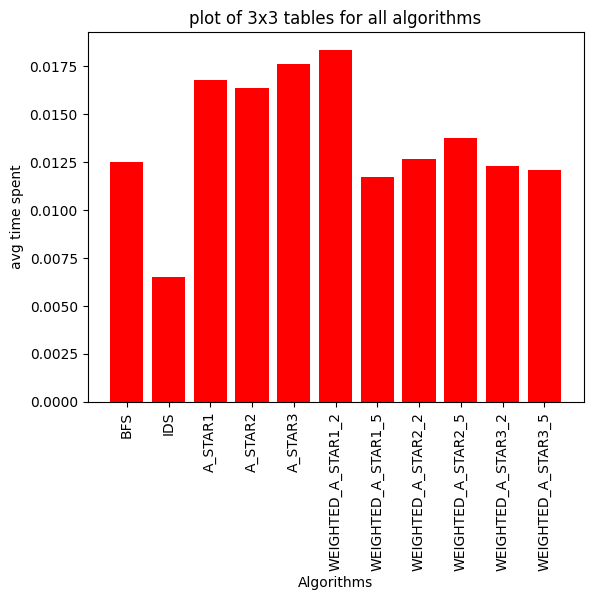

In [20]:
"""
* The plot of 3x3 tables for all algorithms time comparison
* time comparison
"""
import matplotlib.pyplot as plt

x_values = algos
y_values = dict_algorithms_times_3x3.values()

plt.bar(x_values, y_values, color='red')

plt.title("plot of 3x3 tables for all algorithms")
plt.xlabel('Algorithms')
plt.ylabel("avg time spent")

plt.xticks(rotation=90)

# plt.legend()
plt.show()

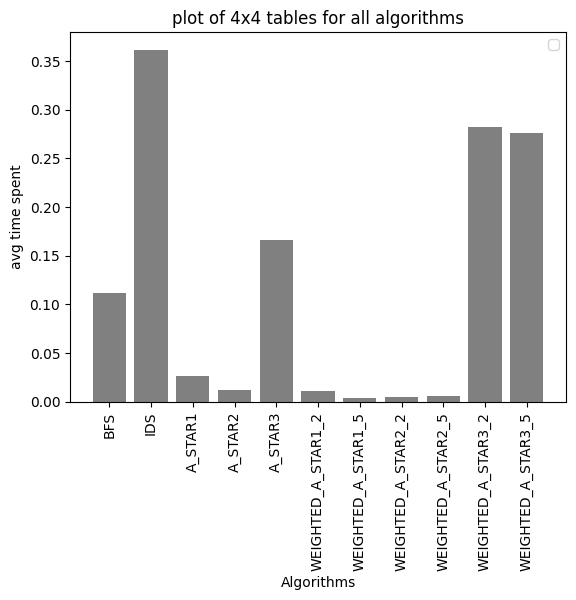

In [21]:
"""
* The plot of 4x4 tables for all algorithms
* time comparison
"""
import matplotlib.pyplot as plt

x_values = algos
y_values = dict_algorithms_times_4x4.values()

plt.bar(x_values, y_values, color='gray')

plt.title("plot of 4x4 tables for all algorithms")
plt.xlabel('Algorithms')
plt.ylabel("avg time spent")

plt.xticks(rotation=90)

plt.legend()
plt.show()

In [22]:
# """
# * The plot of 5x5 tables for all algorithms
# * time comparison
# """
# import matplotlib.pyplot as plt

# x_values = algos
# y_values = dict_algorithms_times_5x5.values()

# plt.bar(x_values, y_values, color="cyan")

# plt.title("plot of 5x5 tables for all algorithms")
# plt.xlabel('Algorithms')
# plt.ylabel("avg time spent")

# plt.xticks(rotation=90)

# plt.legend()
# plt.show()

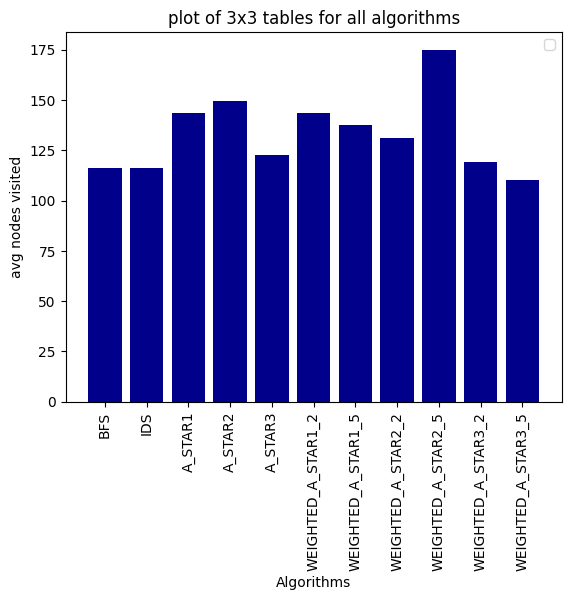

In [23]:
"""
* The plot of 3x3 tables for all algorithms
* nodes visited comparison
"""
import matplotlib.pyplot as plt

x_values = algos
y_values = dict_algorithms_nodes_3x3.values()

plt.bar(x_values, y_values, color='darkblue')

plt.title("plot of 3x3 tables for all algorithms")
plt.xlabel('Algorithms')
plt.ylabel("avg nodes visited")

plt.xticks(rotation=90)

plt.legend()
plt.show()

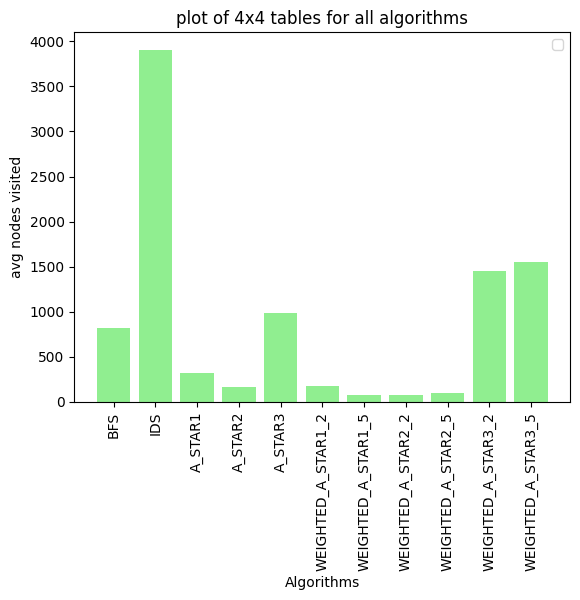

In [24]:
"""
* The plot of 4x4 tables for all algorithms
* nodes visited comparison
"""
import matplotlib.pyplot as plt

x_values = algos
y_values = dict_algorithms_nodes_4x4.values()

plt.bar(x_values, y_values, color="lightgreen")

plt.title("plot of 4x4 tables for all algorithms")
plt.xlabel('Algorithms')
plt.ylabel("avg nodes visited")

plt.xticks(rotation=90)

plt.legend()
plt.show()

In [25]:
# """
# * The plot of 5x5 tables for all algorithms
# * nodes visited comparison
# """
# import matplotlib.pyplot as plt

# x_values = algos
# y_values = dict_algorithms_nodes_5x5.values()

# plt.bar(x_values, y_values)

# plt.title("plot of 5x5 tables for all algorithms")
# plt.xlabel('Algorithms')
# plt.ylabel("avg nodes visited")

# plt.xticks(rotation=90)

# plt.legend()
# plt.show()